# Influence calculation

In [1]:
import pandas as pd
import sqlite3
from petsc4py import PETSc
from slepc4py import SLEPc
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cmath

In [2]:
# Sample meta data
meta = pd.DataFrame({
    'root_id': [11, 127, 1001],
    'top_nt': ['glutamate', 'gaba', 'serotonin'],
    'seed_01': ['olfactory', None, None],
    'super_class': ['sensory', None, None]
})

# Sample connectivity data
edgelist_simple = pd.DataFrame({
    'pre': [11, 11, 127, 127],
    'post': [127, 1001, 11, 127],
    'count': [100, 100 , 100, 100],
    'norm': [0.5, 1, 1, 0.5]
})

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('toy_network_example.sqlite')

# Write DataFrames to the database
meta.to_sql('meta', conn, index=False, if_exists='replace')
edgelist_simple.to_sql('edgelist_simple', conn, index=False, if_exists='replace')

# Close the connection
conn.close()

In [3]:
def plot_graph(G, edge_labels,  edge_widths):
    """ Plot Graph from edgelist or connectivity matrix """
    plt.figure(figsize=(5, 4))
    pos = nx.spring_layout(G, seed=1) 

    nx.draw_networkx_nodes(G, pos, node_size=800, 
                        node_color="skyblue", alpha=0.9)

    nx.draw_networkx_edges(G, pos, width=edge_widths, 
                        arrowstyle='-|>', arrowsize=20, 
                        connectionstyle='arc3,rad=0.3', 
                        edge_color='gray')

    nx.draw_networkx_labels(G, pos, font_size=12, 
                            font_weight='bold')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=10, label_pos=0.8)

    plt.title("Neural Graph from Connectivity Matrix", fontsize=16, 
            fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

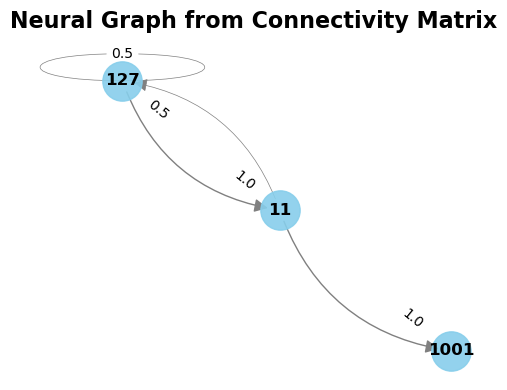

In [4]:
# Plot neural graph from edgelist

G = nx.from_pandas_edgelist(edgelist_simple, source='pre', 
                            target='post', 
                            create_using=nx.DiGraph())

norm_attrs = {(row['pre'], row['post']): row['norm']for _, 
              row in edgelist_simple.iterrows()}
nx.set_edge_attributes(G, norm_attrs, 'norm')

edge_labels = {(u, v): G[u][v]['norm'] for u, v in G.edges()}
edge_widths = [G[u][v]['norm'] for u, v in G.edges()]

plot_graph(G, edge_labels,  edge_widths)


In [5]:
from InfluenceCalculator import InfluenceCalculator

# Build InfluenceCalculator object
ic = InfluenceCalculator('toy_network_example.sqlite')

# Convert petsc matrix to numPy array
connectivity_matrix = ic.W.getValues(range(ic.W.getSize()[0]), 
                                     range(ic.W.getSize()[1]))

print(f"connectivity matrix:\n {connectivity_matrix}")



connectivity matrix:
 [[0.5 0.  0.5]
 [0.  0.  1. ]
 [1.  0.  0. ]]


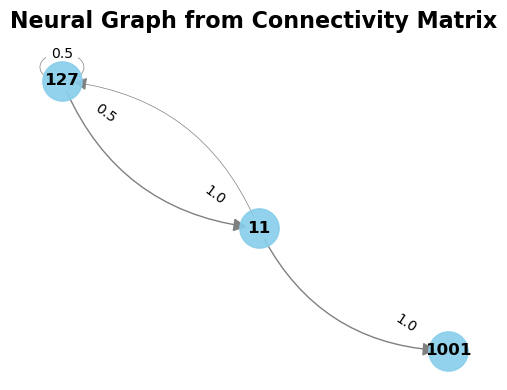

In [6]:
# Plot neural graph from connectivity matrix
H = nx.DiGraph()
num_neurons = connectivity_matrix.shape[0]

for post_idx in range(num_neurons):
    for pre_idx in range(num_neurons):
        weight = connectivity_matrix[post_idx, pre_idx]
        if weight != 0:
            pre_neuron = ic.id_to_index.inv[pre_idx]
            post_neuron = ic.id_to_index.inv[post_idx]
            H.add_edge(pre_neuron, post_neuron, weight=weight)

edge_labels = nx.get_edge_attributes(H, 'weight')
edge_widths = [H[u][v]['weight'] for u, v in H.edges()]

plot_graph(H, edge_labels,  edge_widths)


In [7]:
# Find largest eigenvalue with numpy.linalg
eig_val, _ = np.linalg.eig(connectivity_matrix)
eig_val_largest = np.max(np.real(eig_val))
print(f"Largest eigenvalue (real part): {eig_val_largest}")

# Rescale connectivity matrix
connectivity_matrix_rescaled = (0.99 / np.real(eig_val_largest)) * connectivity_matrix
# Substract the identitiy matrix
A = connectivity_matrix_rescaled - np.eye(3)
print(f"A matrix:\n {A}")

Largest eigenvalue (real part): 1.0
A matrix:
 [[-0.505  0.     0.495]
 [ 0.    -1.     0.99 ]
 [ 0.99   0.    -1.   ]]


In [8]:
# Define seed vector
seed_vec = [0,0,1]
# Calculate steady-sate solution
r_inf = np.dot(-np.linalg.inv(A), seed_vec)
print(f"influence vector:\n{r_inf}")


influence vector:
[33.11036789 33.44147157 33.77926421]


In [9]:
meta_column = 'seed_01'
seed_category = 'olfactory'

# Get neuron ids to inhibit (sensory neurons in this case)
silenced_neurons = ic.meta[
    ic.meta['super_class'].isin(['sensory',
                                    'ascending_sensory'])].root_id

# Get seed neuron ids
seed_ids = ic.meta[ic.meta[meta_column] == seed_category].root_id 

influence_df = None
influence_df = ic.calculate_influence(seed_ids, silenced_neurons)

In [10]:
influence_df

,matrix_index,id,is_seed,Influence_score_(unsigned)
0,0,127,False,33.110368
1,1,1001,False,33.441472
2,2,11,True,33.779264
